<a href="https://colab.research.google.com/github/KevinLolochum/NLP/blob/main/NLP_sentiment_Analysis_(Embedding_vs_LSTM_vs_GRU).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

RNNs are very important in NLP because they are able to keep the the sequence of words deep into the network. LSTMs, a type of RNNs is very good at keeping important words in a sentence and remembering them deep into the network.

In this example of sentiment analysis I demonstrate the difference in performance between an embedding only deep neural network and one where an RNN layer like Gated Reccurrent unit (GRU) or Long Short Term Memory (LSTM) is icluded.

I use the movie reviews tensorflow dataset to demonstrate this.

In [2]:
# NLP tasks imports
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Python data libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [3]:
# I will use the GLUE movie reviews dataset for training and testing
data, info = tfds.load('glue/sst2', with_info=True)
print(info.features)
print(info.features["label"].num_classes)
print(info.features["label"].names)


Shuffling and writing examples to /root/tensorflow_datasets/glue/sst2/1.0.0.incompleteH9C7K7/glue-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/glue/sst2/1.0.0.incompleteH9C7K7/glue-validation.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/glue/sst2/1.0.0.incompleteH9C7K7/glue-test.tfrecord


Dataset glue downloaded and prepared to /root/tensorflow_datasets/glue/sst2/1.0.0. Subsequent calls will reuse this data.
FeaturesDict({
    'idx': tf.int32,
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    'sentence': Text(shape=(), dtype=tf.string),
})
2
['negative', 'positive']


# Splitting data to training and validation and transformation

In [4]:
# Getting the training and the validation dataset and checking dtypes and data
Training_data, Validation_data = data['train'], data['validation']

# Viewing some entries
for example in Training_data.take(2):  
  review, label = example["sentence"], example["label"]
  print("Review:", review)
  print("Label: %d \n" % label.numpy())



Review: tf.Tensor(b'for the uninitiated plays better on video with the sound ', shape=(), dtype=string)
Label: 0 

Review: tf.Tensor(b'like a giant commercial for universal studios , where much of the action takes place ', shape=(), dtype=string)
Label: 0 



Extracitng reviews and and labels and turning to tensors

In [5]:
# Split data to sentences and labels corpus
training_reviews = []
training_labels = []
 
validation_reviews = []
validation_labels = []

for entry in Training_data:
  review, label = entry['sentence'], entry['label']
  training_reviews.append(str(review.numpy()))
  training_labels.append(label.numpy())

for entry in Validation_data:
  review, label = entry['sentence'], entry['label']
  validation_reviews.append(str(review.numpy()))
  validation_labels.append(label.numpy())

# Make labels into numpy arrays for use with the network later
training_labels_final = np.array(training_labels)
validation_labels_final = np.array(validation_labels)

# Tokenizing, sequencing and padding the reviews

In [12]:
# tokenize both the training and testing dataset

# A reasonable revie has about 40-50 important words, the rest might be stop words so I will cap review length at 50
vocab_size =15000
embedding_dim = 16
max_length = 50 
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

tokenizer = Tokenizer(num_words= vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_reviews)
word_index = tokenizer.word_index

# Sequencing and padding
sequence = tokenizer.texts_to_sequences(training_reviews)
padded = pad_sequences(sequences=sequence, maxlen=max_length, padding=padding_type, truncating=trunc_type)

validation_sequences = tokenizer.texts_to_sequences(validation_reviews)
validation_padded = pad_sequences(sequences=validation_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

## An embedding model

In [7]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense, Bidirectional, LSTM, Dropout, GRU
from tensorflow.keras.callbacks import EarlyStopping



Emodel= Sequential()
Emodel.add(Embedding(vocab_size, embedding_dim, input_length=max_length ))
Emodel.add(GlobalAveragePooling1D())
Emodel.add(Dense(6, activation ='relu'))
Emodel.add(Dense(1, activation= 'sigmoid'))

# Compiling
Emodel.compile(optimizer = 'adam', loss= 'binary_crossentropy', metrics = ['accuracy'])

# Model training with early stopping when the val_loss is no longer increasing.

callback = EarlyStopping(monitor= 'val_loss', patience = 6)
num_epochs = 30
history = Emodel.fit(padded, training_labels_final, epochs=num_epochs, validation_data=(validation_padded, validation_labels_final), callbacks = [callback])


Epoch 1/30
2105/2105 [==============================] - 9s 4ms/step - loss: 0.5733 - accuracy: 0.6805 - val_loss: 0.4468 - val_accuracy: 0.8096
Epoch 2/30
2105/2105 [==============================] - 9s 4ms/step - loss: 0.3289 - accuracy: 0.8585 - val_loss: 0.4640 - val_accuracy: 0.8222
Epoch 3/30
2105/2105 [==============================] - 10s 5ms/step - loss: 0.2700 - accuracy: 0.8814 - val_loss: 0.5121 - val_accuracy: 0.8039
Epoch 4/30
2105/2105 [==============================] - 9s 4ms/step - loss: 0.2426 - accuracy: 0.8924 - val_loss: 0.5466 - val_accuracy: 0.8028
Epoch 5/30
2105/2105 [==============================] - 9s 4ms/step - loss: 0.2266 - accuracy: 0.8987 - val_loss: 0.5868 - val_accuracy: 0.8028
Epoch 6/30
2105/2105 [==============================] - 9s 4ms/step - loss: 0.2168 - accuracy: 0.9024 - val_loss: 0.6020 - val_accuracy: 0.8154
Epoch 7/30
2105/2105 [==============================] - 9s 4ms/step - loss: 0.2095 - accuracy: 0.9048 - val_loss: 0.6269 - val_accuracy

Model provides decent accuracy but stops after 7 epochs after loss stops improving. Training accuracy continues going up, possible overfitting.

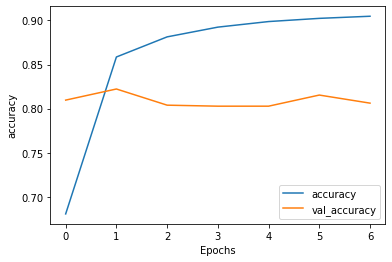

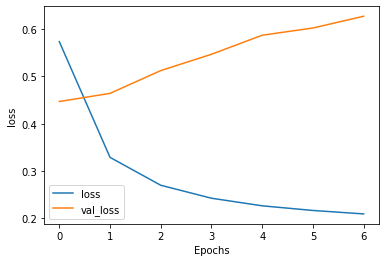

In [8]:
# Visualizing the accuracy and loss graphs

def plots(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

  

plots(history, 'accuracy')

plots(history, 'loss')



GRUs and LSTMs

In [18]:
# Function that compiles, tains model and shows results for model

# Compiling and training
def fit_train(model):
  model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate= 0.00003), loss = 'binary_crossentropy', metrics=['accuracy'])
  history = model.fit(padded, training_labels_final, epochs = num_epochs, 
                      validation_data=(validation_padded, validation_labels_final), callbacks= [callback])
  return history


def plot_results (history):
  plots(history, "accuracy")
  plots(history, "loss")




## Bidirection LSTM model.

LSTM helps keep context of related words using 'cell state', where in the forget-gate, it forgets words that are not important. The words from earlier states (reviews) can be carried forward if they are important so that they can affect the context of later states that are not immidiate neighbors.

In [78]:
from keras.regularizers import L2

LSTM_model  = Sequential()
LSTM_model.add(Embedding(vocab_size, embedding_dim, input_length= max_length))
LSTM_model.add(Bidirectional(LSTM(embedding_dim, kernel_regularizer= L2(0.01), recurrent_regularizer= L2(0.01), bias_regularizer= L2(0.01))))
LSTM_model.add(Dense(4, activation= 'relu'))
LSTM_model.add(Dropout(0.6))
LSTM_model.add(Dense(1, activation= 'sigmoid'))


In [79]:
fit_train(LSTM_model)

Epoch 1/30
2105/2105 [==============================] - 22s 10ms/step - loss: 1.5739 - accuracy: 0.5553 - val_loss: 1.3645 - val_accuracy: 0.5092
Epoch 2/30
2105/2105 [==============================] - 21s 10ms/step - loss: 1.2186 - accuracy: 0.5578 - val_loss: 1.1060 - val_accuracy: 0.5092
Epoch 3/30
2105/2105 [==============================] - 22s 10ms/step - loss: 1.0230 - accuracy: 0.5578 - val_loss: 0.9647 - val_accuracy: 0.5092
Epoch 4/30
2105/2105 [==============================] - 22s 10ms/step - loss: 0.9182 - accuracy: 0.5578 - val_loss: 0.8911 - val_accuracy: 0.5092
Epoch 5/30
2105/2105 [==============================] - 22s 11ms/step - loss: 0.8626 - accuracy: 0.5578 - val_loss: 0.8515 - val_accuracy: 0.5092
Epoch 6/30
2105/2105 [==============================] - 22s 11ms/step - loss: 0.8295 - accuracy: 0.5578 - val_loss: 0.8235 - val_accuracy: 0.5092
Epoch 7/30
2105/2105 [==============================] - 22s 11ms/step - loss: 0.8033 - accuracy: 0.5578 - val_loss: 0.7988 -

Model seemed to overfit at first but improved significantly after I introduced some techniques to reduce variance.

The L2 regularization implimented in this model was also very important at keeping the loss value very low and the loss improved significantly over the epochs.

Data seems to favor a simple model.



## GRU model

In [19]:
GRU_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32)),
    tf.keras.layers.Dropout(0.6),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [20]:
fit_train(GRU_model)

Epoch 1/30
2105/2105 [==============================] - 21s 10ms/step - loss: 0.6866 - accuracy: 0.5566 - val_loss: 0.6954 - val_accuracy: 0.5092
Epoch 2/30
2105/2105 [==============================] - 20s 9ms/step - loss: 0.6776 - accuracy: 0.5597 - val_loss: 0.6718 - val_accuracy: 0.5528
Epoch 3/30
2105/2105 [==============================] - 20s 10ms/step - loss: 0.6060 - accuracy: 0.6681 - val_loss: 0.5454 - val_accuracy: 0.7351
Epoch 4/30
2105/2105 [==============================] - 20s 9ms/step - loss: 0.5238 - accuracy: 0.7529 - val_loss: 0.5276 - val_accuracy: 0.7374
Epoch 5/30
2105/2105 [==============================] - 20s 9ms/step - loss: 0.4705 - accuracy: 0.7899 - val_loss: 0.5288 - val_accuracy: 0.7603
Epoch 6/30
2105/2105 [==============================] - 20s 9ms/step - loss: 0.4317 - accuracy: 0.8135 - val_loss: 0.5266 - val_accuracy: 0.7764
Epoch 7/30
2105/2105 [==============================] - 20s 9ms/step - loss: 0.3976 - accuracy: 0.8307 - val_loss: 0.5308 - val_

The two RNN models initially seemed to overfit on the training data and not generalize the validation data very well. 

After applying variance reduction techniques like L2 regularization, model performance improveed and shows great promise of doing much better.

 Data seems to favor simpler models and GRU outperforms LSTM slightly.

# Using the model to predict sentiment of new reviews

In [11]:
# Function to predict review

def predict_review(model, reviews):
  # Sequence review
  padding_type='post'
  sample_sequences = tokenizer.texts_to_sequences(reviews)
  reviews_padded = pad_sequences(sample_sequences, padding=padding_type, 
                                 maxlen=max_length) 
  classes = model.predict(reviews_padded)
  for x in range(len(reviews_padded)):
    print(reviews[x])
    print(classes[x])
    print('\n')


In [17]:
Sample_reviews = ["I am not dissapointed at this one", 
                "Movie is absolutely lovely",
                "I have watched this movie for a second time now", 
                "Movies with Bruce Barner are always cool", 
                "Lack of regard for environment and animals",
                "Well acted!"
                  
]

In [18]:
predict_review(model= Emodel, reviews = Sample_reviews)

I am not dissapointed at this one
[0.1098248]


Movie is absolutely lovely
[0.99951446]


I have watched this movie for a second time now
[0.43039882]


Movies with Bruce Barner are always cool
[0.99721307]


Lack of regard for environment and animals
[0.8686186]


Well acted!
[0.96632487]




In [19]:
predict_review(model= GRU_model, reviews = Sample_reviews)

I am not dissapointed at this one
[0.11236002]


Movie is absolutely lovely
[0.9945949]


I have watched this movie for a second time now
[0.28962457]


Movies with Bruce Barner are always cool
[0.99692494]


Lack of regard for environment and animals
[0.65973353]


Well acted!
[0.7796829]




Models do a good job in classifying but still gets some reviews wrong.